In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate as 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "mlr_hier_cov_slow"
rank = 30
n = 5000
signal_to_noise = 4


nsamples = 300
L = 6

ranks = np.array([14, 6, 4, 3, 2, 1])

In [4]:
hpart = mf.random_hpartition(n, n, level_list=list(range(L-1)) + [int(np.ceil(np.log2(n)))], symm=True, perm=True)
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=5000.0
level=1, num_groups=2, mean_size=2500.0
level=2, num_groups=4, mean_size=1250.0
level=3, num_groups=8, mean_size=625.0
level=4, num_groups=16, mean_size=312.5
level=5, num_groups=5000, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=28.95142542915701, noise_var=7.150831628949085
SNR=4.048679500710301, signal_to_noise=4


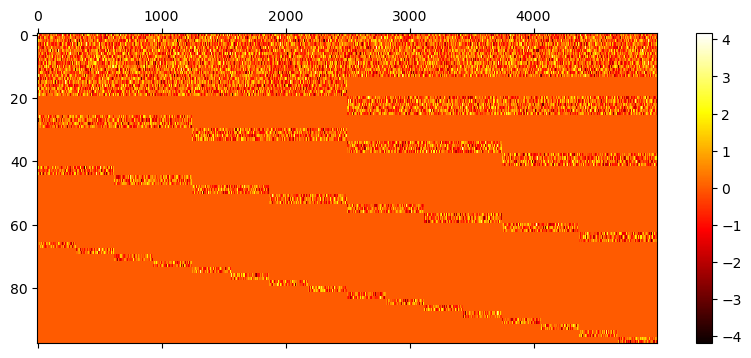

(5000, 98)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)

Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [8]:
C.shape, Z.shape, unpermuted_A.shape

((5000, 300), (5000, 300), (5000, 5000))

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)
permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

num_levels=6, num_sparsities=16
(16, 5) [ 0  1  3  7 15]


# True model loglikelihoods

In [11]:
true_F, true_D = true_mlr.B[:, :-1]+0, true_D_noise+0
true_mfm = mfm.MFModel(F=true_F, D=true_D, hpart=F_hpart, ranks=ranks)

true_train_obj = mfm.fast_loglikelihood_value(true_F, true_D, Y, ranks, permuted_F_hpart,
                                           tol1=1e-5, tol2=1e-5)
exp_true_obj = mfm.fast_exp_true_loglikelihood_value(true_F, true_D, ranks, F_hpart,
                                           tol1=1e-5, tol2=1e-5)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_obj}")

TR: train ll=-11534.5325344717, exp ll=-11536.310803584474


In [12]:
true_mfm.inv_coefficients()

In [13]:
mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        true_mfm, ranks, hpart["rows"], F_hpart, 
                                                        row_selectors, si_groups, tol1=1e-12, tol2=1e-12)

-11536.31080358447

# Frobenius norm-based loss

In [14]:
frob_mfm, losses = mfm.fast_frob_fit_loglikehood(unpermuted_A, Y, F_hpart, hpart, ranks, printing=True, eps_ff=1e-3)

obj_frob = mfm.fast_loglikelihood_value(frob_mfm.F, frob_mfm.D, Y, ranks, permuted_F_hpart)
frob_mfm.inv_coefficients()
obj_frob_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        frob_mfm, ranks, hpart["rows"], F_hpart, 
                                                        row_selectors, si_groups, tol1=1e-12, tol2=1e-12)
print(f"FR: train ll={obj_frob}, test ll={obj_frob_exp}")
obj_frobs = {str(ranks):{"exp":obj_frob_exp, "train":obj_frob}}

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.2634191004275579, [14  6  4  3  2  1]
itr=1, 0.2634191004275579, [14  6  4  3  2  1]
itr=1, 0.22817724088024657, [14  6  4  3  2  1], time_v_epoch=6.487243890762329, time_loss=0.37381482124328613
itr=2, 0.22038419853322275, [14  6  4  3  2  1], time_v_epoch=6.538180112838745, time_loss=0.3583700656890869
itr=3, 0.21710408050274954, [14  6  4  3  2  1], time_v_epoch=6.282227277755737, time_loss=0.3512289524078369
itr=4, 0.21574939292963735, [14  6  4  3  2  1], time_v_epoch=6.09619927406311, time_loss=0.3561389446258545
itr=5, 0.2151926765427125, [14  6  4  3  2  1], time_v_epoch=6.151295900344849, time_loss=0.3768432140350342
itr=6, 0.21496258463511617, [14  6  4  3  2  1], time_v_epoch=6.3451457023620605, time_loss=0.3719348907470703
itr=7, 0.2148665241339222, [14  6  4  3  2  1], time_v_epoch=6.303115606307983, time_loss=0.3620009422302246
FR: train ll=-11293.696152145663, test ll=-11884.339729997155


In [15]:
print(f"FR: train ll={obj_frob}, exp ll={obj_frob_exp}")

FR: train ll=-11293.696152145663, exp ll=-11884.339729997155


# MLE-based loss

In [16]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=400, freq=100)

t=0, obj=-15828.549017611675
t=100, obj=-11313.22081148485
t=200, obj=-11292.031827361718
t=300, obj=-11284.116753747237
t=399, obj=-11279.904528824385


In [17]:
ll_hier = np.copy(np.array(loglikelihoods))

In [18]:
fitted_mfm.inv_coefficients()
obj_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        fitted_mfm, ranks, hpart["rows"], F_hpart, 
                                                        row_selectors, si_groups, tol1=1e-12, tol2=1e-12)

print(f"ML: train ll={loglikelihoods[-1]}, exp ll={obj_exp}")
ll_hier = {"train":ll_hier, "exp":obj_exp}

ML: train ll=-11279.904528824385, exp ll=-11869.949536560922


In [20]:
obj_frobs.values()

dict_values([{'exp': -11884.339729997155, 'train': -11293.696152145663}])

In [21]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# true model maximizes the likelihood of test data
assert exp_true_obj > obj_frobs[str(ranks)]["exp"] and exp_true_obj > ll_hier["exp"]
print(exp_true_obj, ll_hier["exp"], obj_frobs[str(ranks)]["exp"])

-11536.310803584474 -11869.949536560922 -11884.339729997155


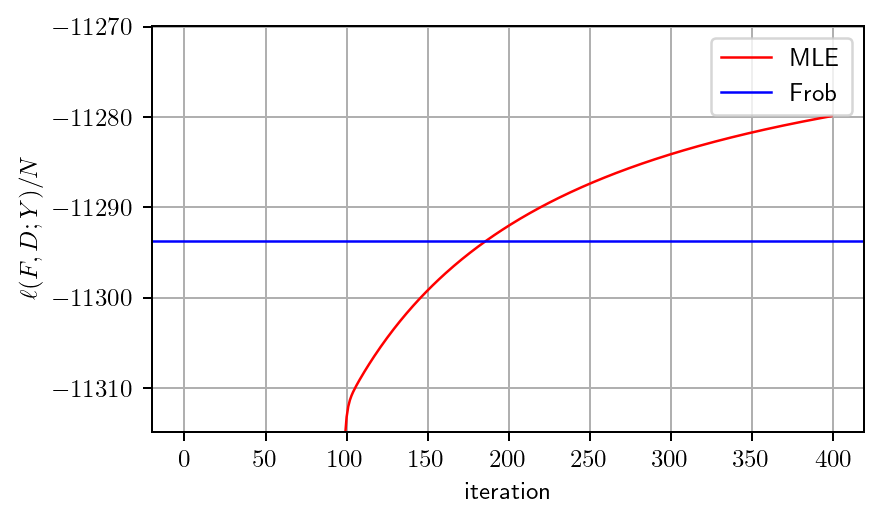

In [23]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = ll_hier["train"][1:]
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frobs[str(ranks)]["train"], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([ll.max() - 35, ll.max() + 10])
# axs.axhline(y=true_test_obj, label='True', c='g', alpha=0.5)
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')